In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

import polars as pl

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    log_loss, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay
)

from itertools import chain, combinations
from scipy.stats import randint, uniform
import xgboost as xgb
from xgboost import XGBClassifier


In [2]:
ticker = yf.Ticker("STZ")
hist = ticker.history(start="2000-01-01", end="2025-05-27").reset_index()

print(hist.columns)
hist.head()


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,5.532425,5.532425,5.234108,5.403606,868800,0.0,0.0
1,2000-01-04 00:00:00-05:00,5.586666,5.640906,5.132411,5.200211,1240000,0.0,0.0
2,2000-01-05 00:00:00-05:00,5.227329,5.383267,5.125629,5.376487,2204800,0.0,0.0
3,2000-01-06 00:00:00-05:00,5.403605,5.634122,5.376485,5.586662,1273600,0.0,0.0
4,2000-01-07 00:00:00-05:00,5.613784,5.810403,5.613784,5.749383,677600,0.0,0.0


In [16]:
hist = hist.drop(columns=["Dividends", "Stock Splits"], errors="ignore")
print(hist.columns)

stz = pl.from_pandas(hist)
print(stz.schema)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Schema([('Date', Datetime(time_unit='ns', time_zone='America/New_York')), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Int64)])


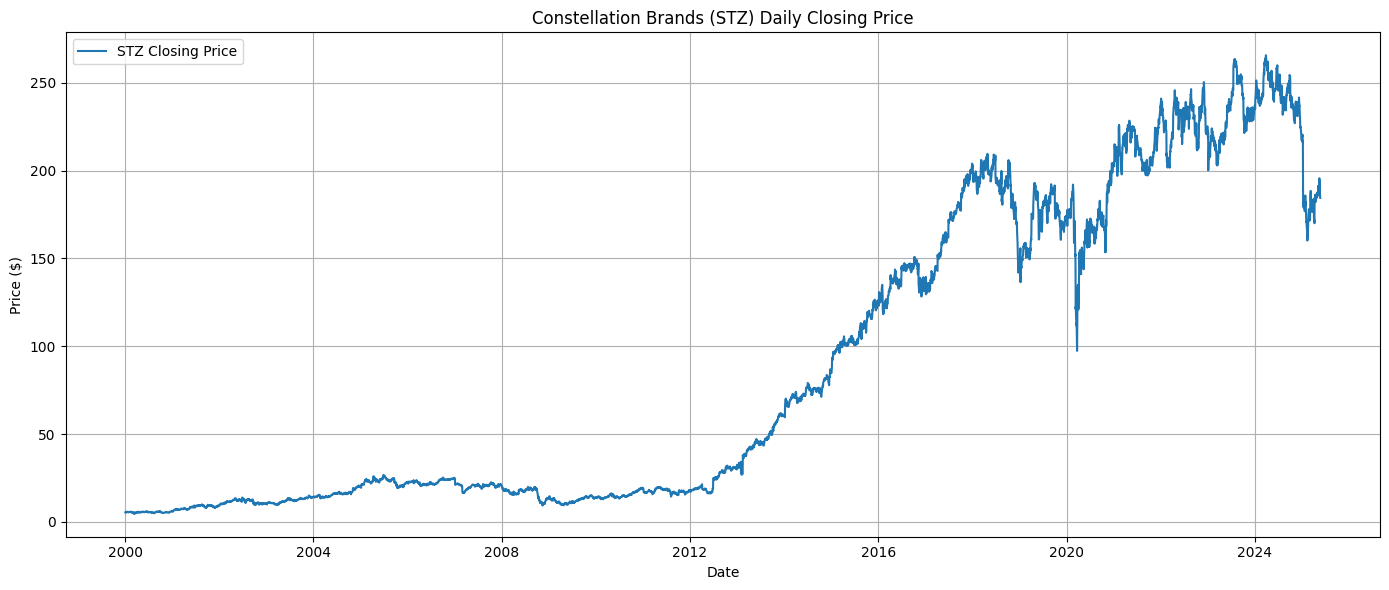

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(hist["Date"], hist["Close"], label="STZ Closing Price", linewidth=1.5)
plt.title("Constellation Brands (STZ) Daily Closing Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
#Create lagged closing prices
stz = stz.with_columns([
    pl.col("Close").shift(1).alias("CloseLag1"),
    pl.col("Close").shift(2).alias("CloseLag2"),
    pl.col("Close").shift(3).alias("CloseLag3")
])

#High minus Low + lags
stz = stz.with_columns([
    (pl.col("High") - pl.col("Low")).alias("HML"),
    (pl.col("High") - pl.col("Low")).shift(1).alias("HMLLag1"),
    (pl.col("High") - pl.col("Low")).shift(2).alias("HMLLag2"),
    (pl.col("High") - pl.col("Low")).shift(3).alias("HMLLag3")
])

#Open minus Close + lags
stz = stz.with_columns([
    (pl.col("Open") - pl.col("Close")).alias("OMC"),
    (pl.col("Open") - pl.col("Close")).shift(1).alias("OMCLag1"),
    (pl.col("Open") - pl.col("Close")).shift(2).alias("OMCLag2"),
    (pl.col("Open") - pl.col("Close")).shift(3).alias("OMCLag3")
])

#Lagged Volume
stz = stz.with_columns([
    pl.col("Volume").cast(pl.Float64).shift(1).alias("VolumeLag1"),
    pl.col("Volume").cast(pl.Float64).shift(2).alias("VolumeLag2"),
    pl.col("Volume").cast(pl.Float64).shift(3).alias("VolumeLag3")
])

#Exponential moving averages (based on lagged Close)
stz = stz.with_columns([
    pl.col("CloseLag1").ewm_mean(half_life=1).alias("CloseEMA2"),
    pl.col("CloseLag1").ewm_mean(half_life=2).alias("CloseEMA4"),
    pl.col("CloseLag1").ewm_mean(half_life=4).alias("CloseEMA8")
])

#Log returns and binary target
stz = stz.with_columns([
    np.log(pl.col("Close") / pl.col("CloseLag1")).alias("LogReturn"),
    pl.when(pl.col("Close") > pl.col("CloseLag1")).then(1).otherwise(0).alias("Target")
])

stz = stz.drop_nulls()

print("Schema:", stz.schema)
print("Final shape:", stz.shape)


Schema: Schema([('Date', Datetime(time_unit='ns', time_zone='America/New_York')), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Int64), ('CloseLag1', Float64), ('CloseLag2', Float64), ('CloseLag3', Float64), ('HML', Float64), ('HMLLag1', Float64), ('HMLLag2', Float64), ('HMLLag3', Float64), ('OMC', Float64), ('OMCLag1', Float64), ('OMCLag2', Float64), ('OMCLag3', Float64), ('VolumeLag1', Float64), ('VolumeLag2', Float64), ('VolumeLag3', Float64), ('CloseEMA2', Float64), ('CloseEMA4', Float64), ('CloseEMA8', Float64), ('LogReturn', Float64), ('Target', Int32)])
Final shape: (6384, 25)


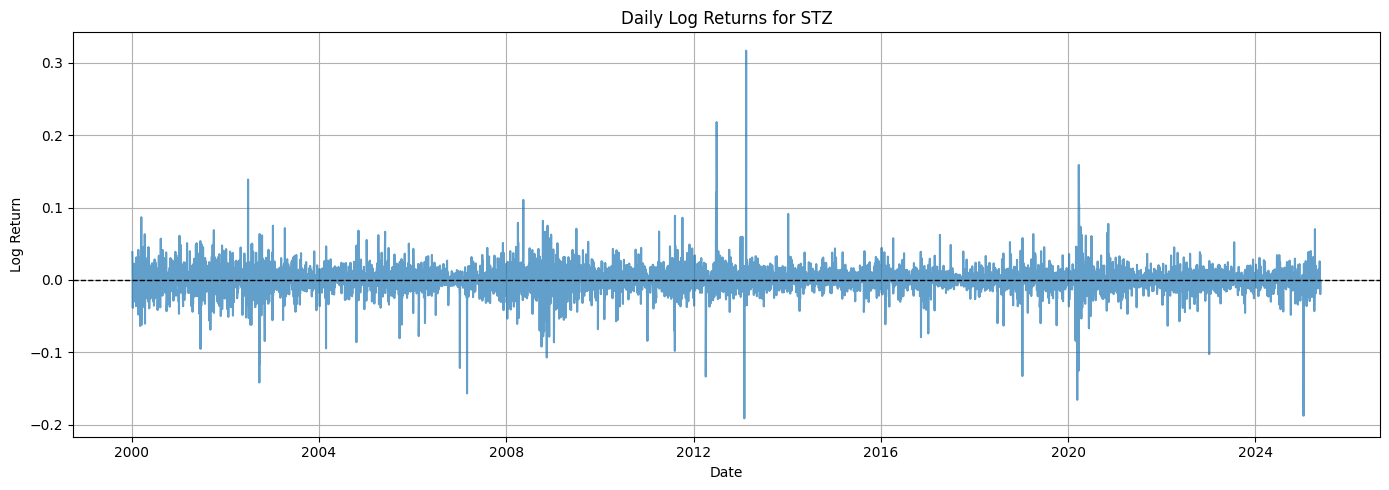

In [22]:
log_returns = stz.select(["Date", "LogReturn"]).to_pandas()
plt.figure(figsize=(14, 5))
plt.plot(log_returns["Date"], log_returns["LogReturn"], alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Daily Log Returns for STZ")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
features = [
    "CloseLag1", "CloseLag2", "CloseLag3",
    "HMLLag1", "HMLLag2", "HMLLag3",
    "OMCLag1", "OMCLag2", "OMCLag3",
    "VolumeLag1", "VolumeLag2", "VolumeLag3",
    "CloseEMA2", "CloseEMA4", "CloseEMA8"
]

X = stz.select(features).to_numpy()
y = stz.select("Target").to_numpy().flatten()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"X shape: {X_scaled.shape}, y shape: {y.shape}")


X shape: (6384, 15), y shape: (6384,)


In [24]:
#Use the 5 best features from prior AIC-style selection
selected_features = ["CloseLag3", "HMLLag1", "OMCLag2", "OMCLag3", "CloseEMA8"]

#Extract selected features and target
X_selected = stz.select(selected_features).to_numpy()
y = stz.select("Target").to_numpy().flatten()

#Scale features
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

#Time series-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=10)

#Initial model (default parameters, 1000 trees)
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=1000,
    random_state=2025
)

cv_results = cross_validate(base_model, X_selected_scaled, y, scoring="accuracy", cv=tscv)
print(f"Initial Accuracy: {np.mean(cv_results['test_score']):.3f}")


Initial Accuracy: 0.498


In [25]:
#Define a randomized hyperparameter grid
param_dist = {
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.5, 0.5),
    "learning_rate": uniform(0.01, 0.1),
    "n_estimators": randint(100, 500),
}

#Run randomized search
search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=2025
    ),
    param_distributions=param_dist,
    n_iter=50,
    scoring="accuracy",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=2025
)

search.fit(X_selected_scaled, y)

print("Best Parameters:", search.best_params_)
print(f"Best Cross-Validated Accuracy: {search.best_score_:.3f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'learning_rate': np.float64(0.10642384192500572), 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 244, 'subsample': np.float64(0.6892024056677444)}
Best Cross-Validated Accuracy: 0.511


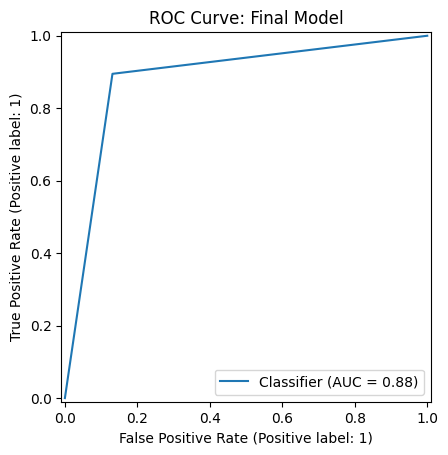

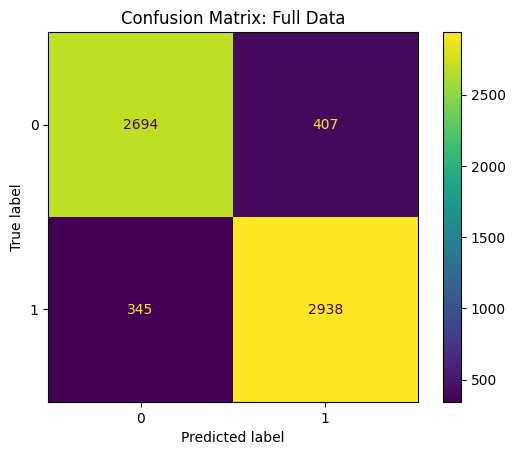

              precision    recall  f1-score   support

   Down/Flat       0.89      0.87      0.88      3101
          Up       0.88      0.89      0.89      3283

    accuracy                           0.88      6384
   macro avg       0.88      0.88      0.88      6384
weighted avg       0.88      0.88      0.88      6384



In [26]:
#Fit final model
final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=2025,
    **search.best_params_
)

final_model.fit(X_selected_scaled, y)
y_pred = final_model.predict(X_selected_scaled)
y_proba = final_model.predict_proba(X_selected_scaled)[:, 1]

RocCurveDisplay.from_predictions(y, y_pred)
plt.title("ROC Curve: Final Model")
plt.show()

ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.title("Confusion Matrix: Full Data")
plt.show()

print(classification_report(y, y_pred, target_names=["Down/Flat", "Up"]))


In [29]:
latest_features = stz.select(selected_features).to_numpy()[-1].reshape(1, -1)
latest_scaled = scaler.transform(latest_features)

predicted_direction = final_model.predict(latest_scaled)[0]
predicted_prob = final_model.predict_proba(latest_scaled)[0][1]

returns_df = stz.select(["Target", "LogReturn"]).to_pandas()
expected_up_return = returns_df[returns_df["Target"] == 1]["LogReturn"].mean()
expected_down_return = returns_df[returns_df["Target"] == 0]["LogReturn"].mean()

expected_return = expected_up_return if predicted_direction == 1 else expected_down_return

latest_close_price = float(stz.select("Close").to_numpy()[-1])

predicted_price = float(latest_close_price * np.exp(expected_return))

print(f"Latest Close Price: ${latest_close_price:.2f}")
print(f"Predicted Direction: {'Up' if predicted_direction == 1 else 'Down/Flat'}")
print(f"Expected Return: {expected_return:.4f}")
print(f"Predicted Next-Day Price: ${predicted_price:.2f}")


Latest Close Price: $184.42
Predicted Direction: Down/Flat
Expected Return: -0.0124
Predicted Next-Day Price: $182.14


In [30]:
#Number of days to simulate
lookback_days = 60

#Create containers
actual_prices = []
predicted_prices = []
predicted_directions = []
actual_directions = []

all_data = stz.select(selected_features + ["Close", "LogReturn", "Target"]).to_pandas().reset_index(drop=True)

#Loop through last 60 days, training up to t, predicting t+1
for i in range(len(all_data) - lookback_days - 1, len(all_data) - 1):
    train_X = all_data[selected_features].iloc[:i].to_numpy()
    train_y = all_data["Target"].iloc[:i].to_numpy()

    test_X = all_data[selected_features].iloc[i].to_numpy().reshape(1, -1)

    #Standardize
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    #Fit model on rolling training data
    model = XGBClassifier(
        **search.best_params_,
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=2025
    )
    model.fit(train_X_scaled, train_y)

    #Predict next-day direction
    pred_dir = model.predict(test_X_scaled)[0]
    predicted_directions.append(pred_dir)

    #Actual next-day close and direction
    actual_next_close = all_data["Close"].iloc[i + 1]
    actual_next_dir = all_data["Target"].iloc[i + 1]
    actual_directions.append(actual_next_dir)

    #Expected return based on predicted direction
    avg_up = all_data["LogReturn"].iloc[:i][all_data["Target"].iloc[:i] == 1].mean()
    avg_down = all_data["LogReturn"].iloc[:i][all_data["Target"].iloc[:i] == 0].mean()
    expected_ret = avg_up if pred_dir == 1 else avg_down

    #Predicted next-day price
    today_close = all_data["Close"].iloc[i]
    pred_price = today_close * np.exp(expected_ret)

    #Store results
    predicted_prices.append(pred_price)
    actual_prices.append(actual_next_close)

dates = stz.select("Date").to_pandas()["Date"].iloc[-lookback_days:].reset_index(drop=True)


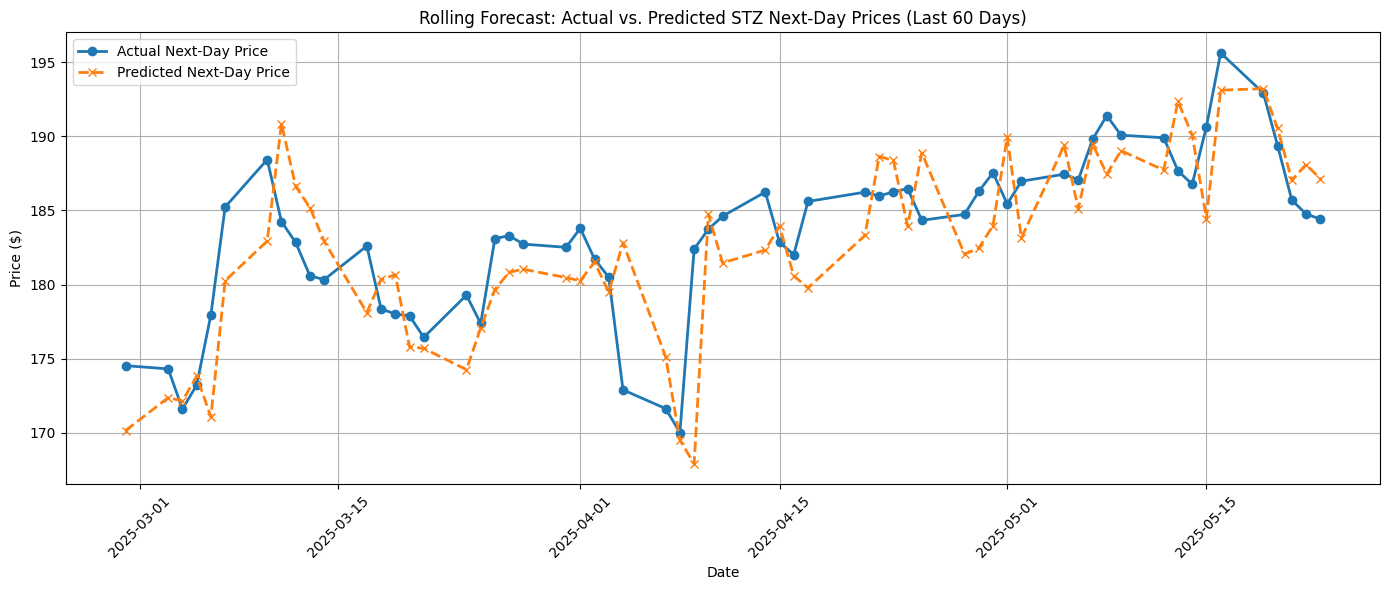

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(dates, actual_prices, label="Actual Next-Day Price", marker='o', linewidth=2)
plt.plot(dates, predicted_prices, label="Predicted Next-Day Price", linestyle='--', marker='x', linewidth=2)
plt.title("Rolling Forecast: Actual vs. Predicted STZ Next-Day Prices (Last 60 Days)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
summary_df = pd.DataFrame({
    "Date": dates,
    "Predicted Direction": ["Up" if d == 1 else "Down" for d in predicted_directions],
    "Actual Direction": ["Up" if d == 1 else "Down" for d in actual_directions],
    "Predicted Price": np.round(predicted_prices, 2),
    "Actual Price": np.round(actual_prices, 2),
})

summary_df["Error ($)"] = summary_df["Predicted Price"] - summary_df["Actual Price"]
summary_df["Error (%)"] = 100 * summary_df["Error ($)"] / summary_df["Actual Price"]
summary_df.head(10)


,Date,Predicted Direction,Actual Direction,Predicted Price,Actual Price,Error ($),Error (%)
0,2025-02-28 00:00:00-05:00,Down,Up,170.16,174.54,-4.38,-2.509453
1,2025-03-03 00:00:00-05:00,Down,Down,172.38,174.32,-1.94,-1.112896
2,2025-03-04 00:00:00-05:00,Down,Down,172.16,171.61,0.55,0.320494
3,2025-03-05 00:00:00-05:00,Up,Up,173.82,173.22,0.60,0.346380
4,2025-03-06 00:00:00-05:00,Down,Up,171.08,177.97,-6.89,-3.871439
5,2025-03-07 00:00:00-05:00,Up,Up,180.26,185.23,-4.97,-2.683151
6,2025-03-10 00:00:00-04:00,Down,Up,182.94,188.43,-5.49,-2.913549
7,2025-03-11 00:00:00-04:00,Up,Down,190.86,184.24,6.62,3.593139
8,2025-03-12 00:00:00-04:00,Up,Down,186.62,182.84,3.78,2.067381
9,2025-03-13 00:00:00-04:00,Up,Down,185.20,180.59,4.61,2.552744


In [33]:
direction_accuracy = np.mean(np.array(predicted_directions) == np.array(actual_directions))
print(f"Directional Accuracy (Last 60 Days): {direction_accuracy:.2%}")

Directional Accuracy (Last 60 Days): 45.00%


In [34]:
!pip install ta --quiet

import ta

stz_df = stz.to_pandas()

#Add technical indicators
stz_df['RSI_14'] = ta.momentum.RSIIndicator(close=stz_df['Close'], window=14).rsi()
macd = ta.trend.MACD(close=stz_df['Close'])
stz_df['MACD'] = macd.macd()
stz_df['MACD_Signal'] = macd.macd_signal()
bb = ta.volatility.BollingerBands(close=stz_df['Close'], window=20)
stz_df['BB_Upper'] = bb.bollinger_hband()
stz_df['BB_Lower'] = bb.bollinger_lband()
stz_df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=stz_df['Close'], volume=stz_df['Volume']).on_balance_volume()

stz_df.dropna(inplace=True)

import polars as pl
stz = pl.from_pandas(stz_df)


  Preparing metadata (setup.py) ... done


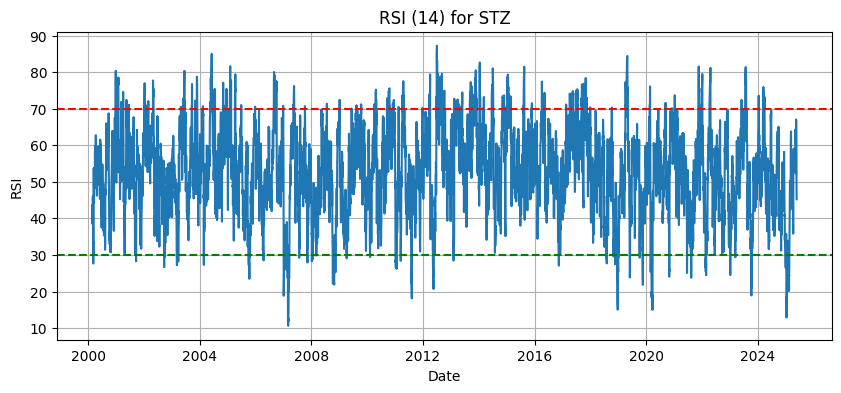

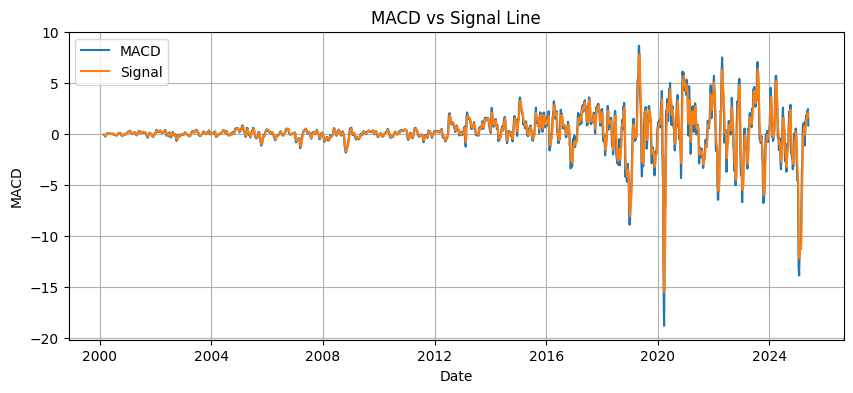

In [35]:
import matplotlib.pyplot as plt

df = stz.to_pandas()

plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['RSI_14'])
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI (14) for STZ')
plt.ylabel('RSI')
plt.xlabel('Date')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['MACD'], label='MACD')
plt.plot(df['Date'], df['MACD_Signal'], label='Signal')
plt.title('MACD vs Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
#Define new feature set (existing 5 + technical indicators)
feature_cols_extended = [
    "CloseLag3", "HMLLag1", "OMCLag2", "OMCLag3", "CloseEMA8",  # existing 5
    "RSI_14", "MACD", "MACD_Signal", "BB_Upper", "BB_Lower", "OBV"  # new features
]

X_ext = df[feature_cols_extended]
y_ext = df['Target']  # same as before

#TimeSeriesSplit and Model Training
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBClassifier

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 10),
    'subsample': np.linspace(0.5, 1.0, 6),
    'n_estimators': range(100, 300, 25),
}

xgb_ext = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

search_ext = RandomizedSearchCV(
    estimator=xgb_ext,
    param_distributions=param_dist,
    n_iter=25,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search_ext.fit(X_ext, y_ext)
print("Best Extended Parameters:", search_ext.best_params_)
print("Best Extended Accuracy:", search_ext.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Extended Parameters: {'subsample': np.float64(0.7), 'n_estimators': 275, 'min_child_weight': 9, 'max_depth': 4, 'learning_rate': np.float64(0.01)}
Best Extended Accuracy: 0.6727788279773157


In [37]:
best_xgb_ext = search_ext.best_estimator_

#Predict direction and expected return on last row
latest_features_ext = X_ext.iloc[-1:].values
predicted_direction_ext = best_xgb_ext.predict(latest_features_ext)[0]
expected_return_ext = best_xgb_ext.predict_proba(latest_features_ext)[0][1] - 0.5

latest_close_price = df['Close'].iloc[-1]
predicted_price_ext = latest_close_price * np.exp(expected_return_ext)

print(f"Latest Close Price: ${latest_close_price:.2f}")
print(f"Predicted Direction: {'Up' if predicted_direction_ext == 1 else 'Down/Flat'}")
print(f"Expected Return: {expected_return_ext:.4f}")
print(f"Predicted Next-Day Price: ${predicted_price_ext:.2f}")


Latest Close Price: $184.42
Predicted Direction: Down/Flat
Expected Return: -0.1790
Predicted Next-Day Price: $154.20


In [42]:
results_ext = []

for i in range(-10, 0):
    X_window = X_ext.iloc[:i]
    y_window = y_ext.iloc[:i]
    X_test_row = X_ext.iloc[i:i+1]

    #Skip if training target is one class only or test row is empty/invalid
    if len(np.unique(y_window)) < 2:
        print(f"Skipping index {i}: y_window contains only one class")
        continue
    if X_test_row.isnull().values.any():
        print(f"Skipping index {i}: X_test_row has NaNs")
        continue

    y_test_row = y_ext.iloc[i]
    actual_close = df['Close'].iloc[i]
    actual_close_prev = df['Close'].iloc[i - 1]
    actual_return = np.log(actual_close / actual_close_prev)

    model = XGBClassifier(**search_ext.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_window, y_window)

    try:
        proba_output = model.predict_proba(X_test_row)
        if proba_output.shape[0] == 0:
            print(f"Skipping index {i}: Empty prediction array")
            continue
        prob = proba_output[0][1]
    except Exception as e:
        print(f"Skipping index {i}: model.predict_proba error - {e}")
        continue

    direction = model.predict(X_test_row)[0]
    expected_return = prob - 0.5
    predicted_price = df['Close'].iloc[i - 1] * np.exp(expected_return)

    results_ext.append({
        "Date": df['Date'].iloc[i],
        "Predicted Direction": "Up" if direction == 1 else "Down",
        "Actual Direction": "Up" if y_test_row == 1 else "Down",
        "Predicted Price": predicted_price,
        "Actual Price": actual_close,
        "Error ($)": predicted_price - actual_close,
        "Error (%)": 100 * (predicted_price - actual_close) / actual_close
    })

results_ext_df = pd.DataFrame(results_ext)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(results_ext_df)



Skipping index -1: Empty prediction array


,Date,Predicted Direction,Actual Direction,Predicted Price,Actual Price,Error ($),Error (%)
0,2025-05-12 00:00:00-04:00,Down,Down,187.09,189.90,-2.81,-1.48
1,2025-05-13 00:00:00-04:00,Down,Down,171.41,187.67,-16.26,-8.66
2,2025-05-14 00:00:00-04:00,Down,Down,156.92,186.76,-29.84,-15.98
3,2025-05-15 00:00:00-04:00,Up,Up,214.32,190.65,23.67,12.41
4,2025-05-16 00:00:00-04:00,Up,Up,231.31,195.62,35.69,18.24
5,2025-05-19 00:00:00-04:00,Up,Down,211.07,192.91,18.16,9.41
6,2025-05-20 00:00:00-04:00,Down,Down,168.17,189.37,-21.20,-11.19
7,2025-05-21 00:00:00-04:00,Down,Down,161.09,185.70,-24.61,-13.25
8,2025-05-22 00:00:00-04:00,Down,Down,162.11,184.76,-22.65,-12.26


Directional Accuracy: 88.89%
Mean Absolute Error (Price): $21.65


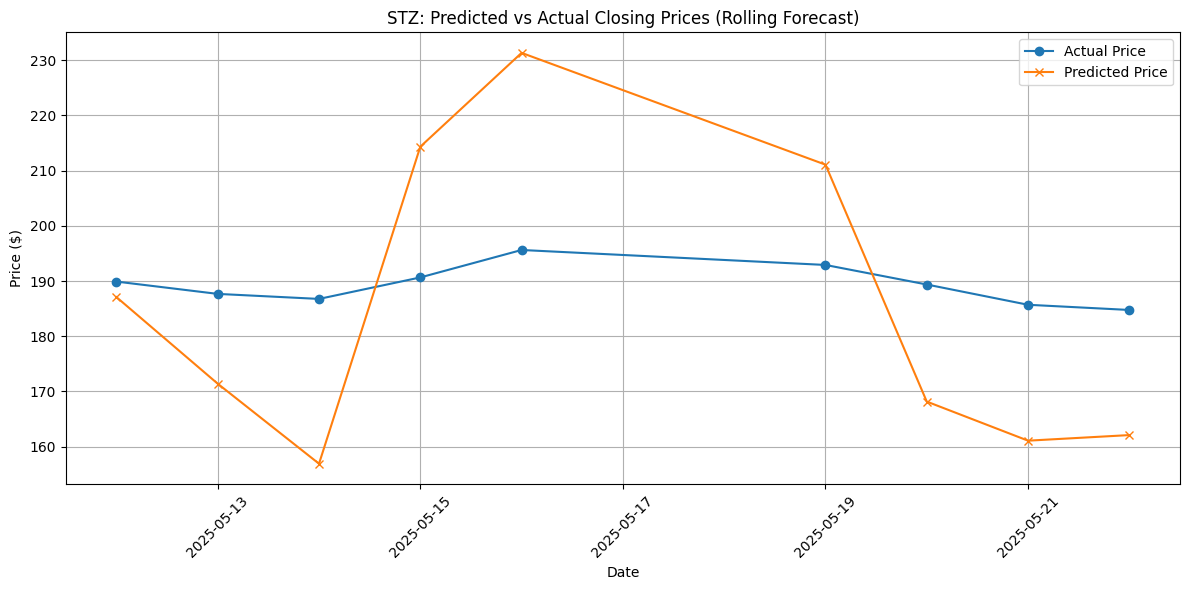

In [43]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt

results_clean = results_ext_df.dropna()

dir_accuracy = accuracy_score(results_clean["Actual Direction"], results_clean["Predicted Direction"])

mae = mean_absolute_error(results_clean["Actual Price"], results_clean["Predicted Price"])

print(f"Directional Accuracy: {dir_accuracy:.2%}")
print(f"Mean Absolute Error (Price): ${mae:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(results_clean["Date"], results_clean["Actual Price"], label="Actual Price", marker='o')
plt.plot(results_clean["Date"], results_clean["Predicted Price"], label="Predicted Price", marker='x')
plt.title("STZ: Predicted vs Actual Closing Prices (Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
